# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/ibtissammim/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 75 (delta 10), reused 5 (delta 5), pack-reused 56 (from 2)
Receiving objects: 100% (75/75), 2.68 MiB | 32.23 MiB/s, done.
Resolving deltas: 100% (22/22), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


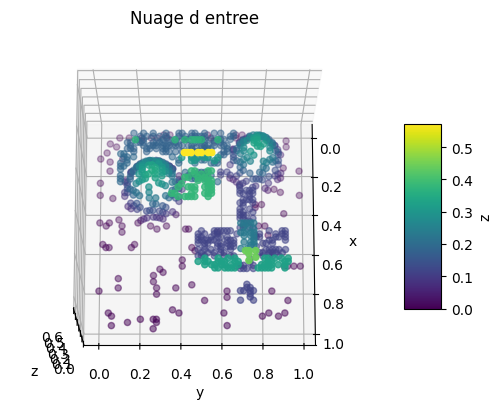

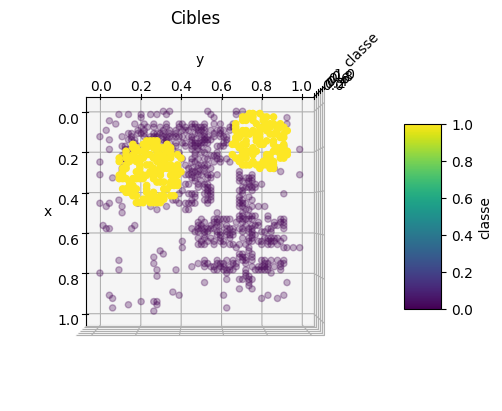

1


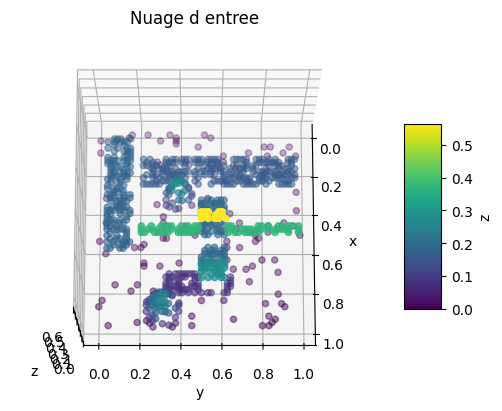

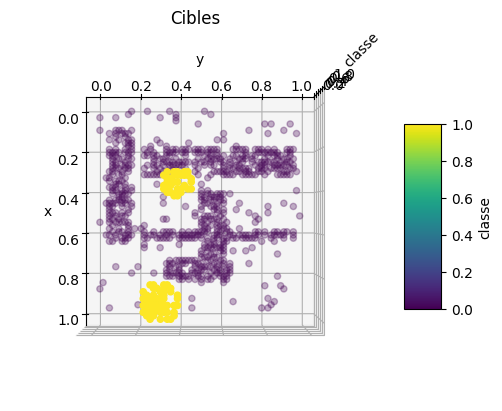

2


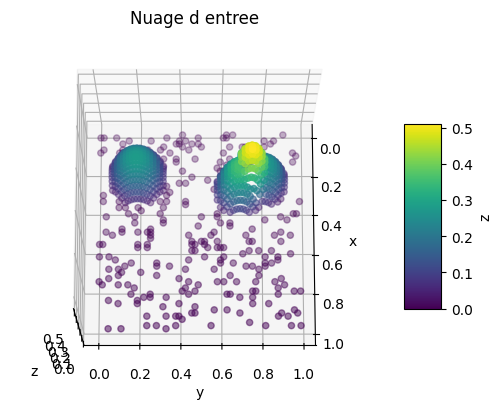

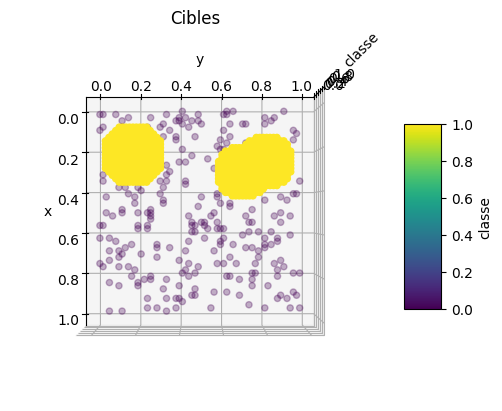

3


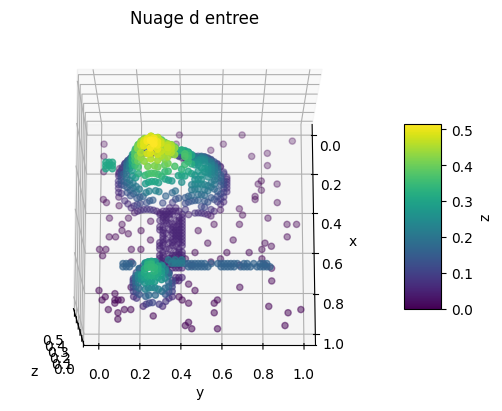

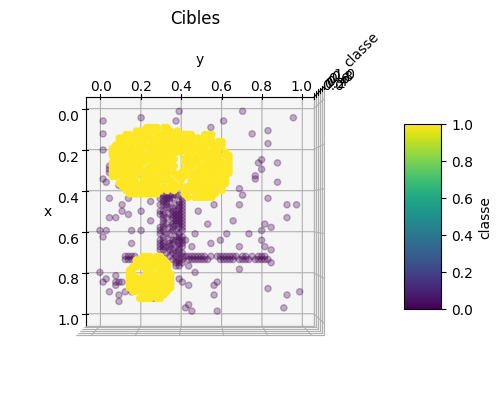

4


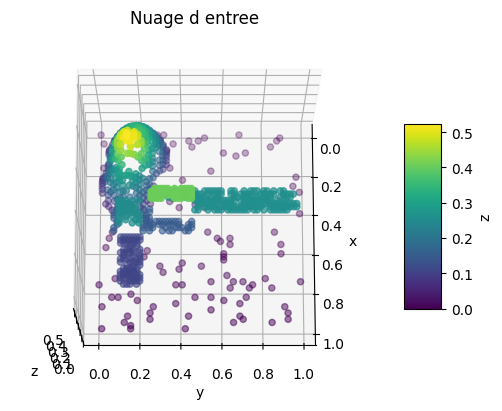

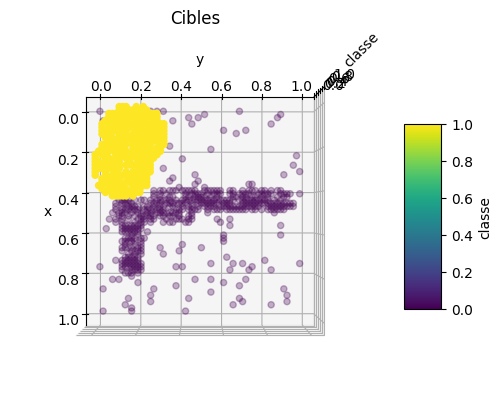

5


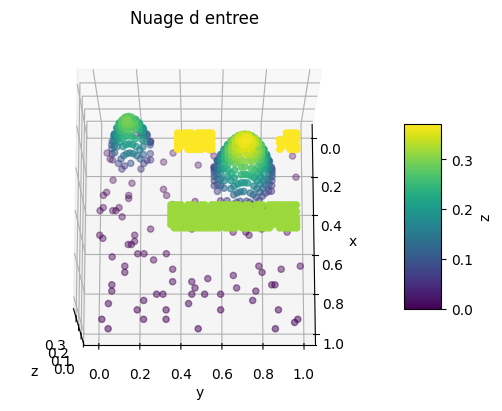

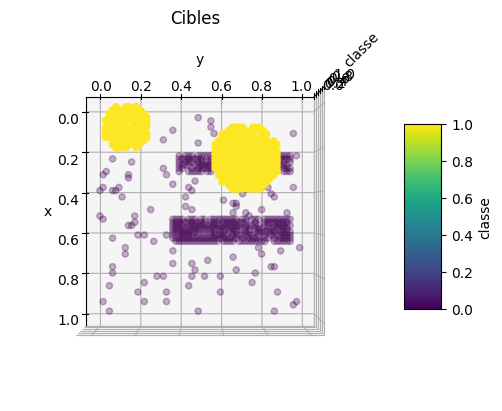

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [4]:
# Les dimensions de input_points correspondent respectivement au numéro du batch,
 # au numéro du point dans le nuage et aux coordonnées x, y, z du point.
input_points.shape

torch.Size([6, 3, 800])

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

In [34]:
# Non, les points d'un nuage ne sont pas rangés dans un ordre particulier, ils sont disposés de manière aléatoire.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

In [35]:
#Je convertirais le nuage de points en une représentation 3D comme une grille de voxels pour un FCN
# ou en projections 2D pour un ViT, puis j'appliquerais le réseau pour la segmentation.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [5]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

D'après l'article , la sortie du modèle PointNet pour la segmentation a les dimensions suivantes : [taille du batch, nombre de points, nombre de classes].

    Taille du batch : Correspond au nombre de nuages de points dans le batch d'entrée.
    Nombre de points : Correspond au nombre de points dans chaque nuage de points.
    Nombre de classes : Correspond au nombre de classes de segmentation possibles (dans ce cas, 2 : igloo ou autre).


In [9]:
output.shape

torch.Size([6, 800, 2])

In [32]:

# Create a random permutation
idx = torch.randperm(input_points.size(1))

# Apply the permutation to the input points
input_points_permuted = input_points[:, idx, :]

# Get the output with permuted input points
output_permuted, _, _ = pointnet(input_points_permuted)

# Comparer les sorties
# Selon l'article sur PointNet, la sortie devrait être invariante à l'ordre des points
# grâce à la fonction symétrique (max pooling dans l'architecture originale) utilisée dans le réseau.

# Check if the difference between the original and permuted output is small, this does not always hold.
difference = torch.norm(output - output_permuted)
print(f"Difference between original and permuted outputs: {difference}")

# La comparaison nous montre que l'invariace à l'ordre de PointNet n'est pas toujours vérifier en pratique, même si théoriquement cela doit être
# le cas.

Difference between original and permuted outputs: 0.0


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

In [38]:

# Opérations conduisant à la segmentation (hors input/feature transform):

# 1. MLPs (Multi-Layer Perceptrons) :  Plusieurs couches MLPs sont appliquées sur chaque point individuellement.  Cela permet d'extraire des caractéristiques locales de chaque point.

# 2. Max Pooling :  Une opération de max pooling est appliquée sur l'ensemble des caractéristiques extraites par les MLPs pour chaque point du nuage.  Cela produit un vecteur de caractéristiques globales, représentatif de tout le nuage de points.  C'est cette opération qui assure l'invariance à l'ordre des points.

# 3. Concaténation : Les caractéristiques globales issues du max pooling sont concaténées avec les caractéristiques locales de chaque point.

# 4. MLPs (seconde série) : Une autre série de couches MLPs est appliquée sur le résultat de la concaténation.  Ces MLPs permettent de combiner les informations locales et globales pour produire une prédiction de classe pour chaque point.

# Le terme "shared" signifie que les mêmes poids sont utilisés pour les MLPs appliqués à chaque point du nuage.  Cela permet de réduire le nombre de paramètres du réseau et d'assurer l'invariance à l'ordre des points.

# Invariance à l'ordre :  L'invariance à l'ordre est assurée principalement par le max pooling.  Puisque le max pooling sélectionne la valeur maximale pour chaque caractéristique sur tous les points, l'ordre dans lequel les points sont présentés n'affecte pas le résultat final. Les MLPs partagés appliquent la même transformation à chaque point, indépendamment de sa position dans le nuage. La concaténation avec les caractéristiques globales (résultat du max pooling) fournit à chaque point l'information contextuelle globale, mais l'ordre d'entrée des points n'a pas d'influence grâce au max pooling.


<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [44]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# Définir les poids alpha manuellement
alpha = torch.tensor([0.2, 0.8]).cuda()  # Convertir en tenseur PyTorch et déplacer sur GPU
gamma = 1

loss_fn = torch.nn.CrossEntropyLoss(weight=alpha, ignore_index=-100).cuda()  # Utiliser 'weight' pour alpha, ignorer -100


# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = output.transpose(1,2)
target_list = target_list.cuda()
loss_fn(proba_pred_list, target_list)

tensor(0.7412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [46]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    optimizer.zero_grad()
    input_points, target_list, _ = gen_pointcloud(batch_size)
    input_points = input_points.cuda()
    target_list = target_list.cuda()

    output, _, _ = pointnet(input_points)
    proba_pred_list = output.transpose(1, 2)
    loss = loss_fn(proba_pred_list, target_list)

    loss.backward()
    optimizer.step()

    # Calculate accuracy
    predicted_labels = torch.argmax(output, dim=2)
    correct_predictions = (predicted_labels == target_list).sum().item()
    total_predictions = target_list.numel()
    accuracy = correct_predictions / total_predictions

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")


epoch :  1
Epoch [2/200], Loss: 0.7131, Accuracy: 0.5670
Epoch [2/200], Loss: 0.7906, Accuracy: 0.4853
Epoch [2/200], Loss: 0.7053, Accuracy: 0.5593
Epoch [2/200], Loss: 0.7794, Accuracy: 0.5050
Epoch [2/200], Loss: 0.7397, Accuracy: 0.5038
Epoch [2/200], Loss: 0.7790, Accuracy: 0.4675
Epoch [2/200], Loss: 0.7724, Accuracy: 0.4961
Epoch [2/200], Loss: 0.7719, Accuracy: 0.4846
Epoch [2/200], Loss: 0.7396, Accuracy: 0.5232
epoch :  2
Epoch [3/200], Loss: 0.7278, Accuracy: 0.5006
Epoch [3/200], Loss: 0.7439, Accuracy: 0.5143
Epoch [3/200], Loss: 0.7083, Accuracy: 0.5456
Epoch [3/200], Loss: 0.7571, Accuracy: 0.5222
Epoch [3/200], Loss: 0.7167, Accuracy: 0.5314
Epoch [3/200], Loss: 0.7371, Accuracy: 0.5211
Epoch [3/200], Loss: 0.7726, Accuracy: 0.4572
Epoch [3/200], Loss: 0.7218, Accuracy: 0.5322
Epoch [3/200], Loss: 0.7545, Accuracy: 0.4732
epoch :  3
Epoch [4/200], Loss: 0.6985, Accuracy: 0.5278
Epoch [4/200], Loss: 0.7310, Accuracy: 0.5013
Epoch [4/200], Loss: 0.7096, Accuracy: 0.5317
E

--2025-01-10 15:51:49--  https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.40, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/c4/87/c48766163a0775a1a0ec83d87695ccdf01e77baf65f77019b3125b730fffb025/7c1831335a0fdde208b94b592c27c5745910a868414cebc6fbc51786ceae6905?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pointnet_500_ep.pth%3B+filename%3D%22pointnet_500_ep.pth%22%3B&Expires=1736783509&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjc4MzUwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2M0Lzg3L2M0ODc2NjE2M2EwNzc1YTFhMGVjODNkODc2OTVjY2RmMDFlNzdiYWY2NWY3NzAxOWIzMTI1YjczMGZmZmIwMjUvN2MxODMxMzM1YTBmZGRlMjA4Yjk0YjU5MmMyN2M1NzQ1OTEwYTg2ODQxNGNlYmM2ZmJjNTE3ODZjZWFlNjkwNT9yZX

<ipython-input-47-01c410006283>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load('pointnet_500_ep.pth')


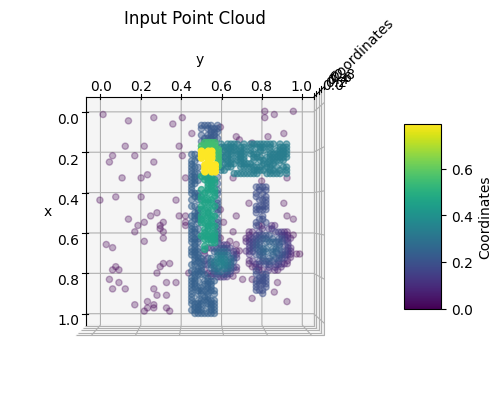

TypeError: plot_triplets() got an unexpected keyword argument 'colors'

In [47]:
# Load pretrained weights
!wget https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth -O pointnet_500_ep.pth
pretrained_weights = torch.load('pointnet_500_ep.pth')
pointnet.load_state_dict(pretrained_weights)

# Visualize outputs of the pretrained model
input_points, _, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

# Example visualization for the first point cloud in the batch
predicted_labels = torch.argmax(output[0], dim=1).cpu().numpy()
for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')


In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
